# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from utils import compute_confusion_matrix, compute_scores

/Users/sofiene.alouini/miniconda3/envs/maker-nlp/lib/python3.9/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Data loading

In [2]:
train_df = pd.read_csv("../data/train.csv").fillna("")
test_df = pd.read_csv("../data/test.csv").fillna("")

# Feature engineering

In [3]:
def relative_length_diff(df: pd.DataFrame) -> pd.Series:
    q1_nb_words = df["q1_text"].str.split().str.len()
    q2_nb_words = df["q2_text"].str.split().str.len()
    max_length = pd.concat([q1_nb_words, q2_nb_words], axis=1).max(axis=1)
    length_diff = (q1_nb_words - q2_nb_words).abs()
    return length_diff / max_length

def relative_nb_question_marks_diff(df: pd.DataFrame) -> pd.Series:
    q1_nb_question_marks = df["q1_text"].str.lower().str.count("\?")
    q2_nb_question_marks = df["q2_text"].str.lower().str.count("\?")
    max_nb_question_marks = pd.concat([q1_nb_question_marks, q2_nb_question_marks], axis=1).max(axis=1)
    nb_question_marks_diff = (q1_nb_question_marks - q2_nb_question_marks).abs()
    return nb_question_marks_diff / max_nb_question_marks

def common_words_ratio(df: pd.DataFrame) -> pd.Series:
    q1_words = df["q1_text"].str.split().map(set)
    q2_words = df["q2_text"].str.split().map(set)
    common_words_ratio = pd.DataFrame({"q1_words": q1_words, "q2_words": q2_words}).apply(
        lambda row: len(row["q1_words"].intersection(row["q2_words"])) / len(row["q1_words"].union(row["q2_words"])),
        axis=1
    )
    return common_words_ratio

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "relative_length_diff": relative_length_diff(df),
        "relative_nb_question_marks_diff": relative_nb_question_marks_diff(df),
        "common_words_ratio": common_words_ratio(df)
    })

# Cleaning

In [4]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "q1_text": df["q1_text"].str.lower().str.replace(r"\W", " ", regex=True).str.replace(r"\s+", " ", regex=True),
        "q2_text": df["q2_text"].str.lower().str.replace(r"\W", " ", regex=True).str.replace(r"\s+", " ", regex=True),
        "is_duplicate": df["is_duplicate"]
    })

In [5]:
clean_train_df = clean_df(train_df)
clean_test_df = clean_df(test_df)

features = {
    "train": create_features(clean_train_df),
    "test": create_features(clean_test_df)
}

targets = {
    "train": clean_train_df["is_duplicate"],
    "test": clean_test_df["is_duplicate"]
}

# Model: Decision Tree

In [6]:
model = DecisionTreeClassifier(max_depth=3, class_weight={0: 1, 1: 1.5})

model.fit(features["train"].fillna(0.), targets["train"])

DecisionTreeClassifier(class_weight={0: 1, 1: 1.5}, max_depth=3)

In [7]:
y_test_true = targets["test"]
y_test_pred = model.predict(features["test"].fillna(0))

In [8]:
compute_scores(y_test_true, y_test_pred)

{'Accuracy': '65.10%', 'Recall': '83.71%', 'Precision': '51.69%'}

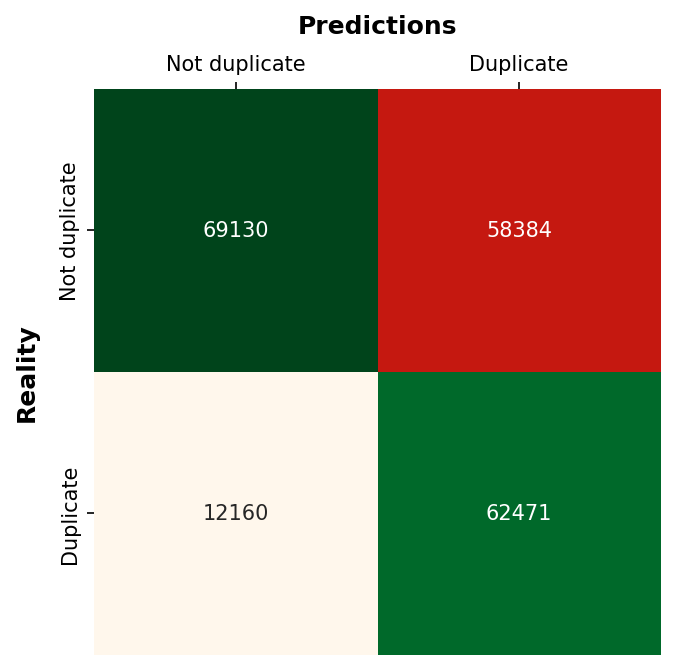

In [9]:
compute_confusion_matrix(y_test_true, y_test_pred, dpi=150)

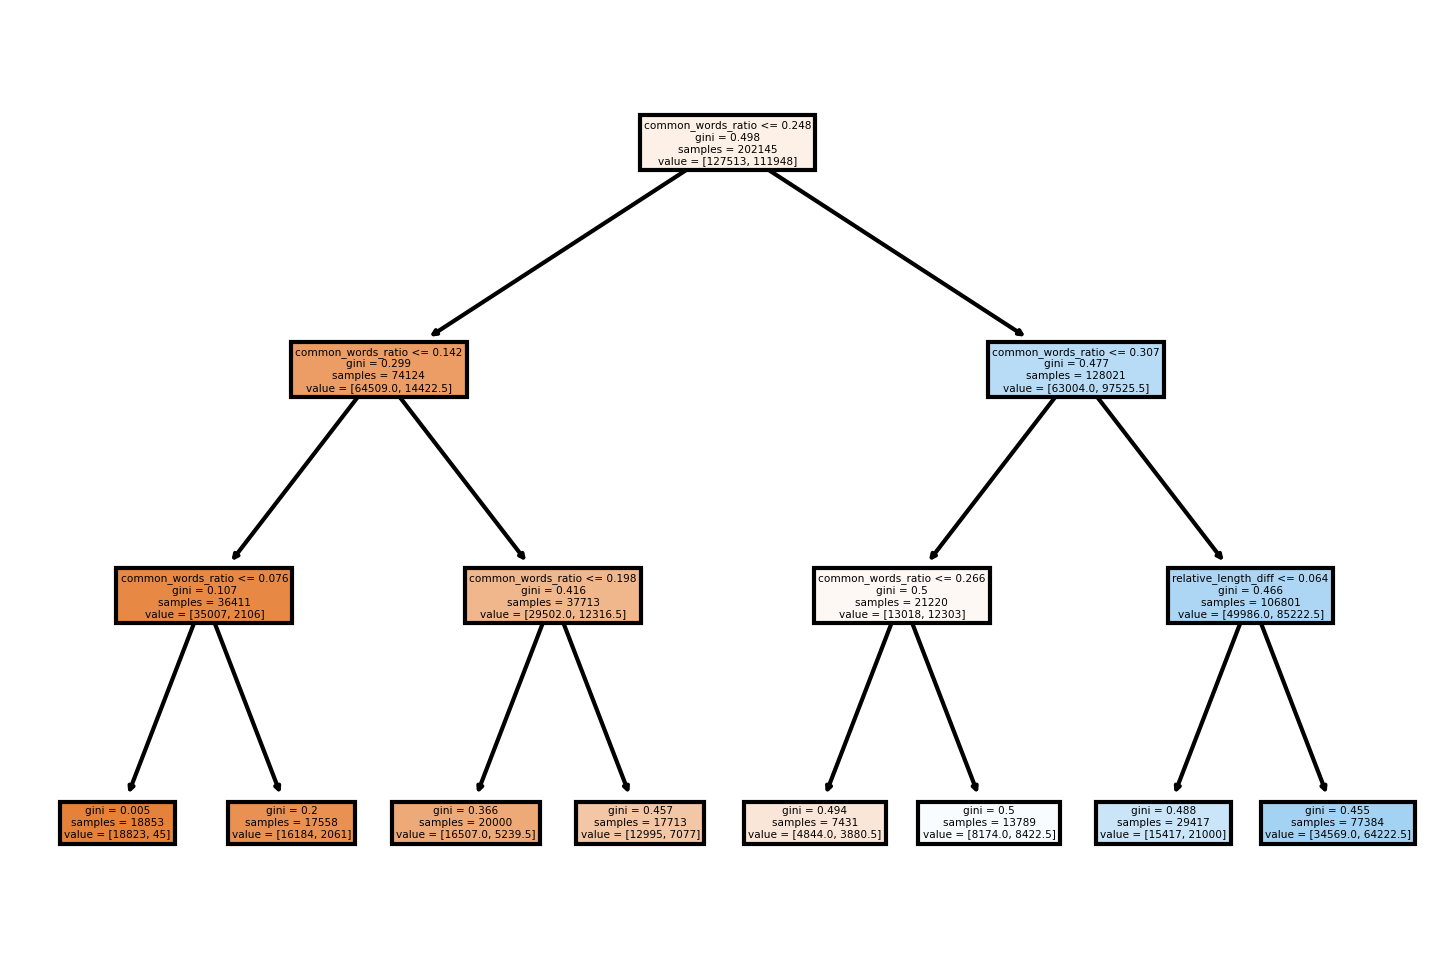

In [10]:
plt.figure(dpi=300)
plot_tree(model, filled=True, feature_names=model.feature_names_in_)
plt.show()

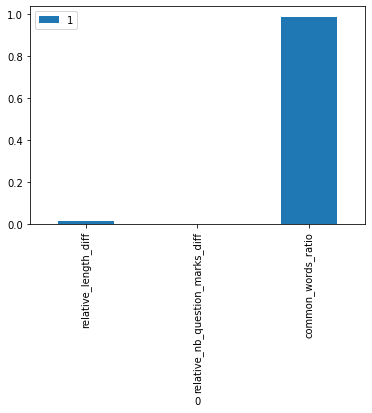

In [11]:
pd.DataFrame(
    list(
        zip(
            model.feature_names_in_,
            model.feature_importances_
        )
    )
).plot.bar(x=0, y=1)

plt.show()